# stitch_by_sat

For each day's satellite acquisitions, grab all the tiles for each satellite and stitch them together into a "satellite chunk". Remove those satellite chunks that cover less than a third of the glacier (evaluated using a glacier outline shapefile).

In [131]:
import rasterio as rio
from rasterio.mask import mask
import cv2
import fiona
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
from scipy.interpolate import interp2d
import glob 
import pandas as pd
from shapely.geometry import mapping
import geopandas as gpd

In [132]:
basepath = '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/' # path to grid standardized images
os.listdir(basepath)

['20200311_200122_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200312_192159_76_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200311_201006_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200314_201145_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200314_173229_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200313_192302_55_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200307_192642_16_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200314_173227_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200311_200116_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200304_203531_13_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200302_204103_24_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200307_192644_21_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200315_200934_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200304_203523_02_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 '20200306_204115_71_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif',
 

In [133]:
# path to study area shapefile
aoi_shp = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/BoxTurner_UTM_07.shp'
aoi_gdf = gpd.read_file(aoi_shp)
aoi = aoi_gdf.geometry.values
print(aoi[0])

POLYGON ((546082.8268453347 6669426.551069965, 559359.2437101691 6682895.37977342, 587703.2183131702 6654956.319093321, 574426.8014483359 6641487.490389868, 546082.8268453347 6669426.551069965))


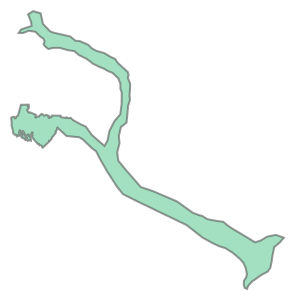

In [134]:
# path to glacier shapefile
glacier_shp = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/main_ice_outline.shp'
glacier_gdf = gpd.read_file(glacier_shp)
glacier = glacier_gdf.geometry.values
glacier[0]

# Coregister and stitch all Planet tiles for each image date

In [135]:
# grab all satellite IDs and dates of imagery
filelist = os.listdir(basepath); filelist.sort()
dates = []; IDs = []; files = []
no_tiles  = 0
for file in filelist:
    if file.startswith('2') and file.endswith('.tif'):
        date = file.split('_')[0] # grab the date
        sID = file.split('_')[-7] # grab the satellite ID (4 digit code)
        dates.append(date); IDs.append(sID); files.append(file) # append to list
        no_tiles+=1
sorted_dates = list(set(list(zip(dates, IDs)))) # set of the zipped date and ID
sorted_dates.sort() # sorted
satdate_df = pd.DataFrame(sorted_dates, columns=['date','sat_ID'])
satdate_df.head()

,date,sat_ID
0,20200301,106f
1,20200302,105a
2,20200302,106b
3,20200303,1058
4,20200303,106c


In [136]:
# Grab the first Planet tile for reference CRS and Transform
reftile = rio.open(basepath+filelist[3])
print(reftile.crs)
print(reftile.transform)
print(reftile.shape)

EPSG:32607
| 4.98, 0.00, 546080.48|
| 0.00,-4.98, 6682898.32|
| 0.00, 0.00, 1.00|
(8317, 8360)


TILES FOR 20200301 106f
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200301_192257_98_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200301_192300_03_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200301_192302_09_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200301_192304_14_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200301_192302_09_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200301_192304_14_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif


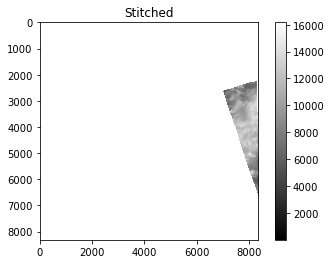

TILES FOR 20200302 105a
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_204055_04_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_204057_09_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_204059_14_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_204101_19_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_204103_24_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_204055_04_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_204103_24_105a_3B_AnalyticMS_SR_har

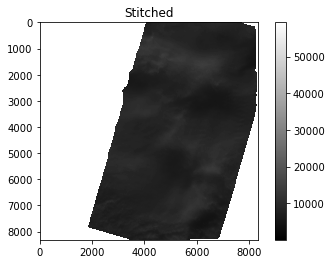

TILES FOR 20200302 106b
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_192327_43_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_192329_49_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_192331_54_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_192333_60_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_192335_65_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200302_192327_43_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


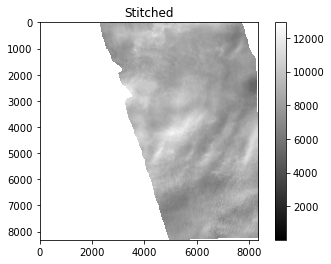

TILES FOR 20200303 1058
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200303_204228_95_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200303_204230_98_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200303_204233_02_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200303_204235_06_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Current tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200303_204235_06_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif


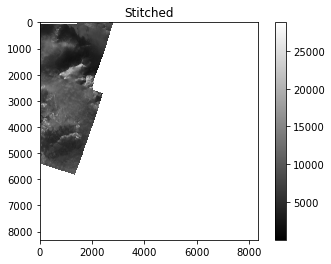

TILES FOR 20200303 106c
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200303_192406_15_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200303_192408_19_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200303_192410_23_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200303_192412_27_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


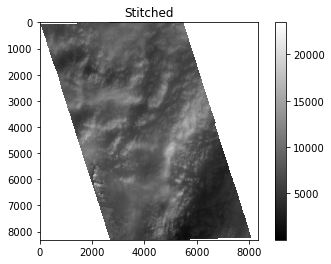

TILES FOR 20200304 1064
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_203523_02_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_203525_05_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_203527_08_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_203529_10_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_203531_13_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_203529_10_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_203531_13_1064_3B_AnalyticMS_SR_har

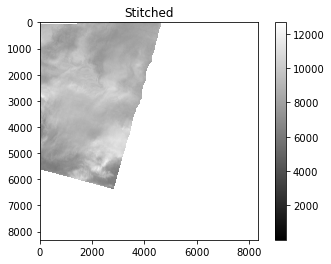

TILES FOR 20200304 1068
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_192438_37_1068_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_192440_43_1068_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_192442_48_1068_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200304_192444_54_1068_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


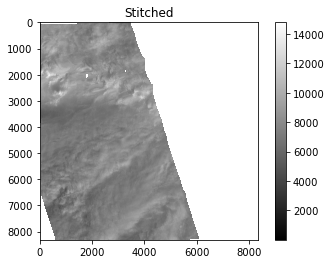

TILES FOR 20200305 106f
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200305_192538_50_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200305_192540_56_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200305_192542_62_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Previous tile is larger.
Previous tile is larger.


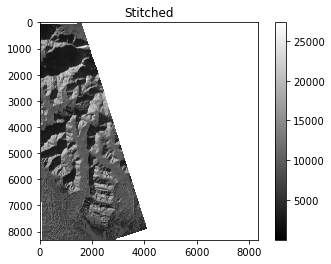

TILES FOR 20200306 105d
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200306_204115_71_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200306_204117_75_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200306_204115_71_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif


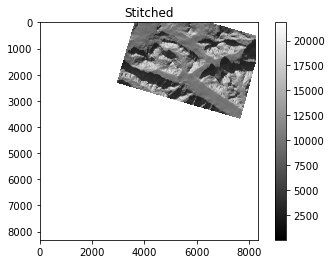

TILES FOR 20200306 106b
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200306_192608_50_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200306_192610_56_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.


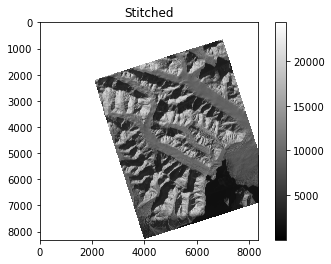

TILES FOR 20200307 106c
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200307_192642_16_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200307_192644_21_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200307_192642_16_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200307_192644_21_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif


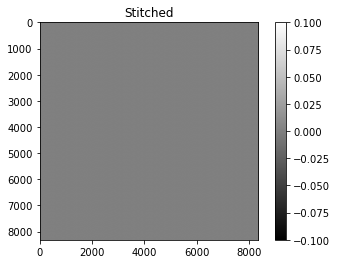

TILES FOR 20200308 105e
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200308_203623_00_105e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200308_203625_05_105e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200308_203627_10_105e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200308_203629_15_105e_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200308_203623_00_105e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.


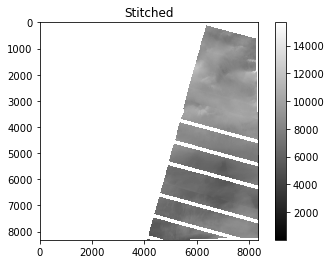

TILES FOR 20200311 0e26
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_200116_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_200117_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_200118_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_200119_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_200120_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_200122_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_200120_0e26_3B_AnalyticMS_SR_harm

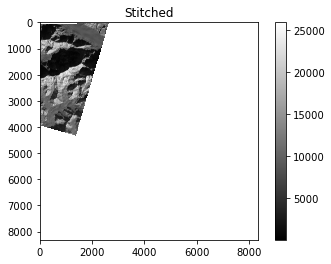

TILES FOR 20200311 1008
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_201001_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_201002_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_201003_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_201004_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_201005_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_201006_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_201001_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PS

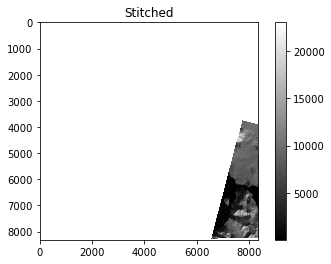

TILES FOR 20200311 106c
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_192917_42_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_192919_48_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200311_192921_53_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Previous tile is larger.
Previous tile is larger.


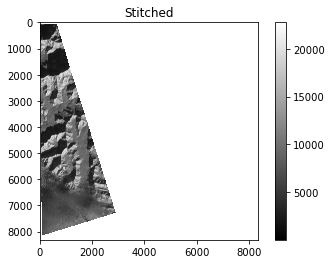

TILES FOR 20200312 1003
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201557_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201558_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201559_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201600_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201601_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201602_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201603_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/stan

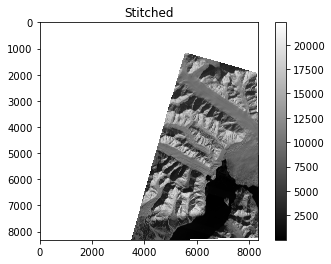

TILES FOR 20200312 101f
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201219_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201221_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201222_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201223_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201224_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201225_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_201226_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous 

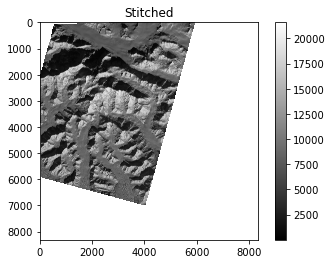

TILES FOR 20200312 1063
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_192159_76_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_192201_85_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_192203_93_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_192206_01_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_192208_09_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_192159_76_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200312_192208_09_1063_3B_AnalyticMS_SR_har

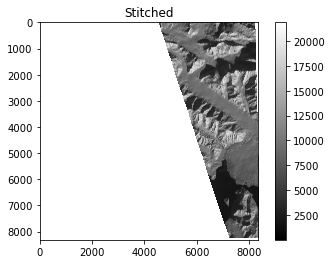

TILES FOR 20200313 1012
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200313_201357_1012_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200313_201357_1012_3B_AnalyticMS_SR_harmonized_clip_5m.tif


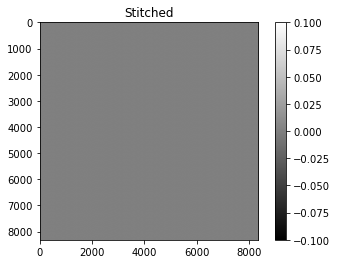

TILES FOR 20200313 105a
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200313_203931_35_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200313_203933_42_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200313_203935_49_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200313_203931_35_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.


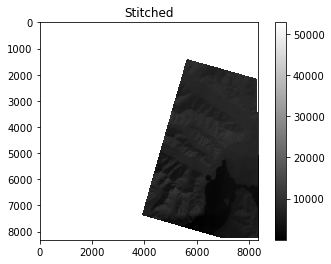

TILES FOR 20200313 106e
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200313_192302_55_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200313_192304_64_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200313_192306_73_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200313_192302_55_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.


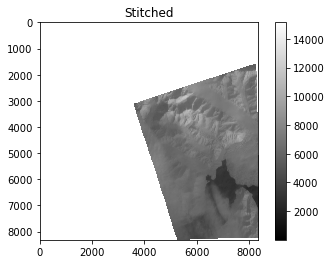

TILES FOR 20200314 0f28
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_201145_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_201147_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_201148_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_201149_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_201150_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_201145_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_201147_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
remove /Volumes/SURGE_DISK

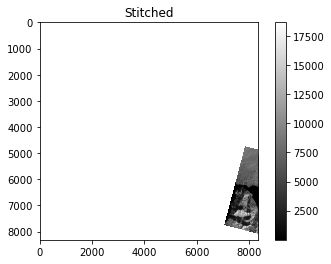

TILES FOR 20200314 0f2e
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_173227_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_173228_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_173229_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_173231_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_173229_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200314_173231_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif


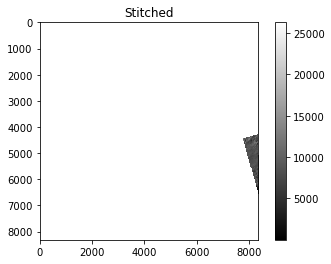

TILES FOR 20200315 1008
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_200933_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_200934_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_200933_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_200934_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif


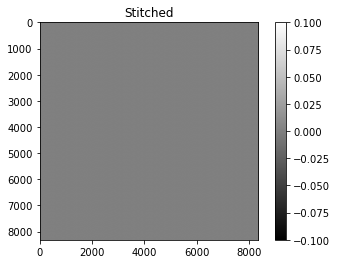

TILES FOR 20200315 1032
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_201743_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_201744_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_201745_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_201746_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_201747_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_201748_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_201749_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous 

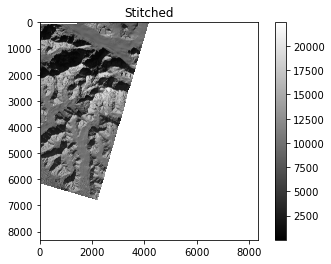

TILES FOR 20200315 1069
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_192357_44_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_192359_50_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_192401_56_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_192403_61_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_192405_67_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200315_192405_67_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif


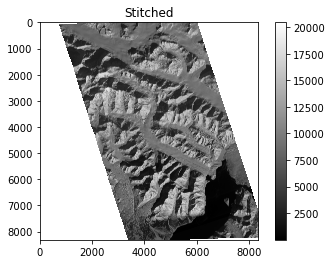

TILES FOR 20200316 0f32
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_172907_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_172908_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_172909_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_172910_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_172911_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_172912_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_172913_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/stan

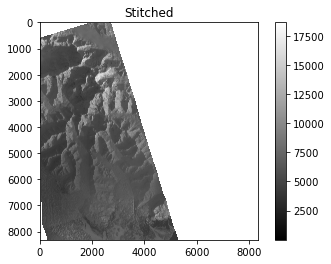

TILES FOR 20200316 1059
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_203620_90_1059_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_203622_95_1059_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Previous tile is larger.


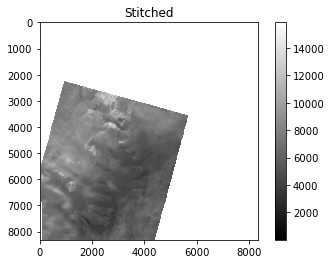

TILES FOR 20200316 1063
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_192429_47_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_192431_56_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_192433_65_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_192435_74_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_192437_83_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200316_192437_83_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif


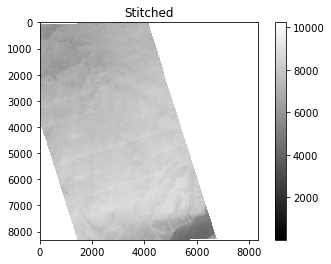

TILES FOR 20200317 100a
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201016_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201017_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201018_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201019_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201016_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201018_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201019_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif


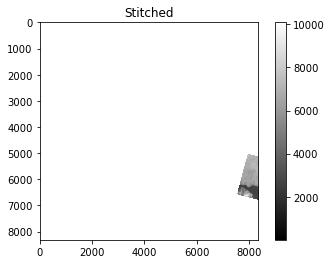

TILES FOR 20200317 1027
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201845_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201847_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201848_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_201848_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif


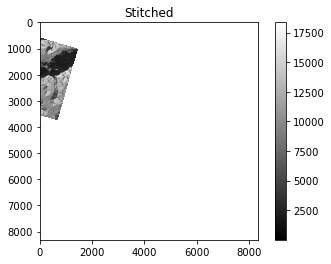

TILES FOR 20200317 106e
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_192533_26_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_192535_36_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_192537_46_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_192539_56_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200317_192533_26_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Previous tile is larger.
Previous tile is larger.


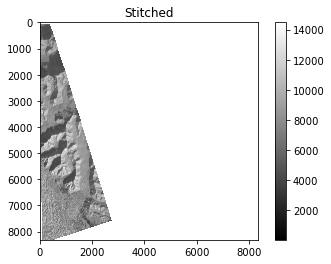

TILES FOR 20200318 106a
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200318_192552_65_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200318_192554_74_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200318_192556_84_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200318_192558_94_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200318_192601_04_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200318_192552_65_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


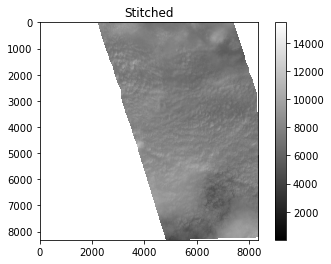

TILES FOR 20200319 0e19
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200319_195420_0e19_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200319_195420_0e19_3B_AnalyticMS_SR_harmonized_clip_5m.tif


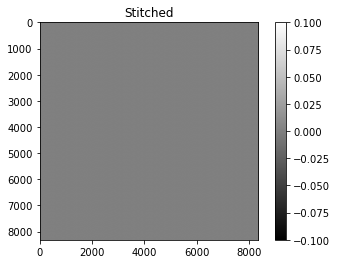

TILES FOR 20200319 1069
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200319_192624_39_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200319_192626_46_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200319_192628_52_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200319_192630_59_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200319_192632_65_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200319_192624_39_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200319_192632_65_1069_3B_AnalyticMS_SR_har

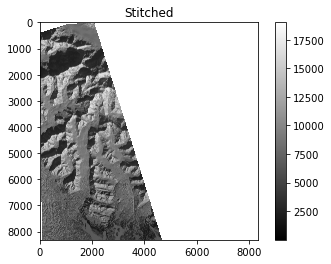

TILES FOR 20200320 1003
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201513_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201514_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201515_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201519_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201520_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201513_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201520_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif


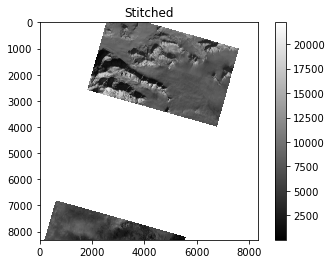

TILES FOR 20200320 103e
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201426_103e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201429_103e_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201426_103e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200320_201429_103e_3B_AnalyticMS_SR_harmonized_clip_5m.tif


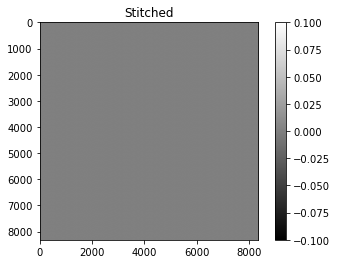

TILES FOR 20200322 1064
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_204116_11_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_204118_15_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_204120_19_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_204122_23_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_204124_27_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_204124_27_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif


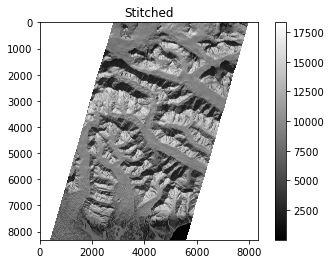

TILES FOR 20200322 106a
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_192818_51_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_192820_61_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_192822_72_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_192824_82_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_192818_51_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200322_192824_82_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif


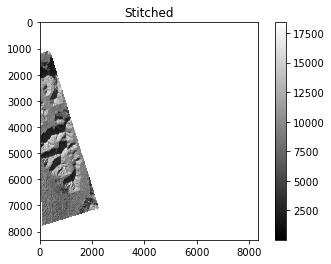

TILES FOR 20200323 0f49
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200323_173024_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200323_173025_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200323_173026_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200323_173027_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200323_173028_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200323_173029_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200323_173029_1_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSSc

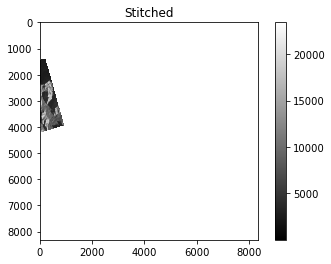

TILES FOR 20200324 1003
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200324_201448_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200324_201449_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200324_201450_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200324_201451_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200324_201448_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200324_201451_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif


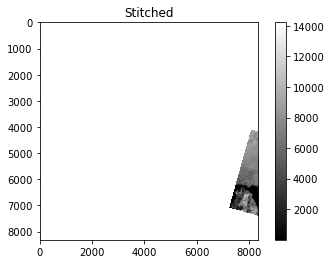

TILES FOR 20200324 1063
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200324_192923_32_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200324_192923_32_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif


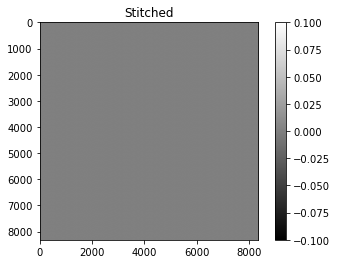

TILES FOR 20200325 100a
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_200930_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_200931_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_200932_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_200930_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_200931_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_200932_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif


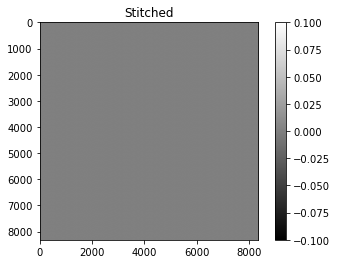

TILES FOR 20200325 1027
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_201753_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_201754_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.


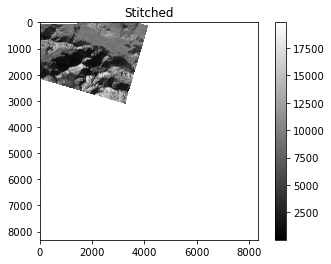

TILES FOR 20200325 106e
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_193025_42_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_193027_52_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_193029_62_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_193031_72_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_193025_42_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_193027_52_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200325_193031_72_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif


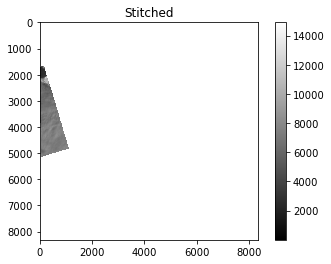

TILES FOR 20200326 0f36
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_172802_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_172803_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_172804_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_172805_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_172806_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_172807_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_172808_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/stan

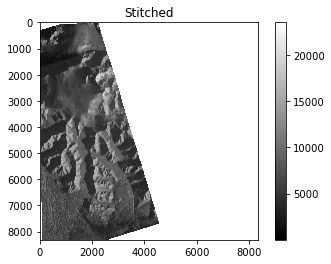

TILES FOR 20200326 0f3c
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_173534_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_173535_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_173536_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_173534_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_173535_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_173536_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif


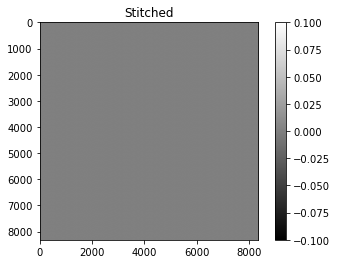

TILES FOR 20200326 1006
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201139_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201140_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201141_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201143_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201144_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201145_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201146_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScen

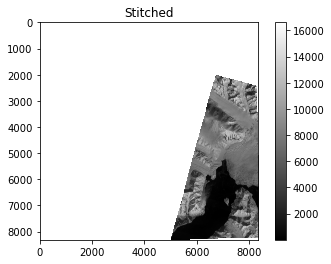

TILES FOR 20200326 103d
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201839_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201840_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201841_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201842_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201843_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201844_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200326_201845_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/stan

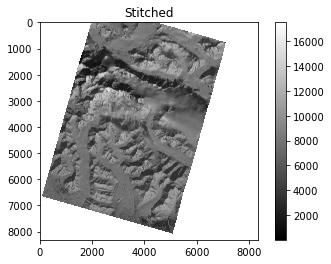

TILES FOR 20200327 0e26
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200327_195953_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200327_195953_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif


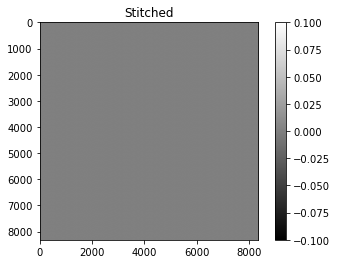

TILES FOR 20200327 1032
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200327_201624_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200327_201624_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif


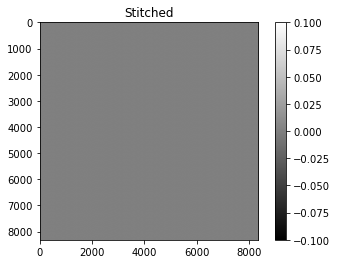

TILES FOR 20200328 105d
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_203754_82_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_203756_85_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_203758_89_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_203800_93_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_203802_97_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_203754_82_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_203802_97_105d_3B_AnalyticMS_SR_har

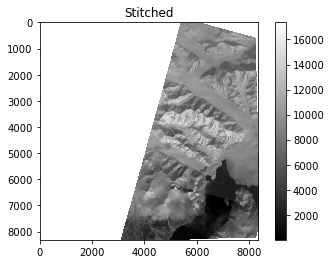

TILES FOR 20200328 1062
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_192356_37_1062_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_192358_47_1062_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_192356_37_1062_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200328_192358_47_1062_3B_AnalyticMS_SR_harmonized_clip_5m.tif


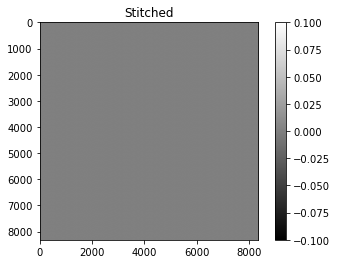

TILES FOR 20200329 0f33
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_172820_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_172821_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_172822_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_172822_1_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_172823_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_172824_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_172825_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/st

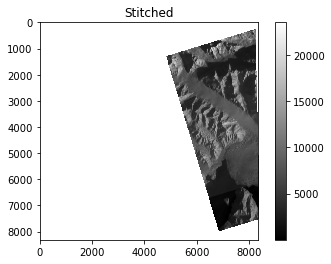

TILES FOR 20200329 1027
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_201723_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_201724_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_201725_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_201726_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_201727_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_201728_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200329_201729_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous 

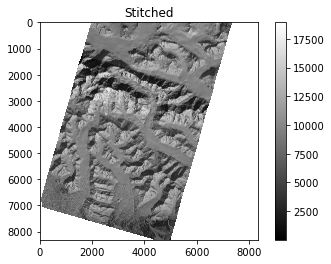

TILES FOR 20200330 0f25
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_201436_0f25_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_201436_0f25_3B_AnalyticMS_SR_harmonized_clip_5m.tif


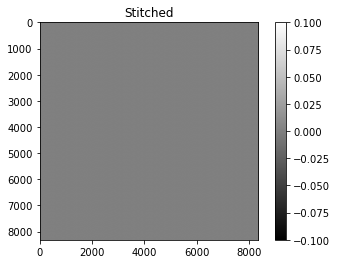

TILES FOR 20200330 0f2a
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172809_0f2a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172810_0f2a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172811_0f2a_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172809_0f2a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172810_0f2a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172811_0f2a_3B_AnalyticMS_SR_harmonized_clip_5m.tif


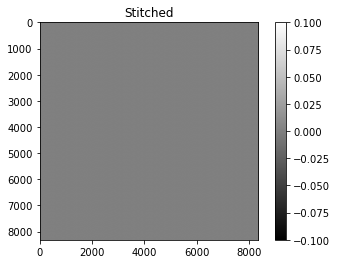

TILES FOR 20200330 104a
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172422_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172422_1_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172423_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172424_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172425_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172426_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_172427_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/st

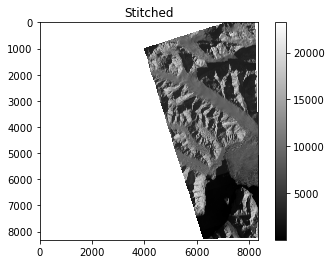

TILES FOR 20200330 1065
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_192450_56_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_192452_66_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_192454_76_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_192456_86_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_192458_96_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/20200330_192458_96_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif


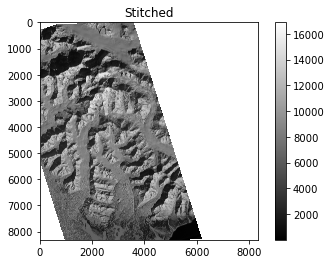

In [137]:
binary_thresh = 1
for idx, row in satdate_df.iterrows():
    date = row.date
    ID = row.sat_ID
    print('TILES FOR', date, ID)
    
    # Grab the Planet tiles corresponding to each unique date
    tiles = glob.glob(basepath+'/'+date+'*'+ID+'*clip_5m.tif') # grab all file paths for that date
    tiles.sort()
    print(tiles)
    
    # initialize empty arrays
    overlap_total = np.zeros(reftile.shape);
    sr_stitched = np.zeros(reftile.shape) # start with empty stitched product
    t = 0 # tile count
    
    for tile in tiles:
        # open image tile, determine overlap with AOI, remove if none
        reader = rio.open(tile); sr = reader.read(1) # load the tile
        try:
            out_image, out_transform = mask(reader, [mapping(aoi[0])], crop=True)
            crop_array = out_image[0,:,:]
            # if no overlapping pixels, remove
#             if np.count_nonzero(~np.isnan(crop_array)) == 0:
            if np.count_nonzero(crop_array[~np.isnan(crop_array)]) == 0:
                print('remove '+tile)
                os.remove(tile)
                continue
        except Exception:
            # if it fails to crop, then remove
#             print('remove '+tile)
            continue
        
        # if there is overlap, continue with processing
        sr[sr == 0] = np.NaN # remove black background, replace with Nans
        sr_data = sr.copy() # make a copy of the data before making the data binary
        sr[sr>0.0] = 1 ; sr[np.isnan(sr)] = 0 # make tile binary
        
        tilesize = np.count_nonzero(sr) # grab the current tile size (pixels)
        overlap_total = overlap_total+sr # add new overlap to overlap total
        
        if t==0: # just add the first one
            sr_stitched = np.nansum([sr_data, sr_stitched],0) # add them to the stitched product
        else:
            # for all subsequent, find the overlapping area:
            overlap_band = ma.masked_not_equal(overlap_total, 2) # identify non-overlapping area (not 2)
            overlap_band_mask = ma.getmaskarray(overlap_band)
            
            # identify which tile is larger
            if tilesize > prev_tilesize:
                print('Current tile is larger.')
                larger_tile = sr_data; smaller_tile = sr_stitched # assign the tiles
            elif tilesize < prev_tilesize:
                print('Previous tile is larger.')
                larger_tile = sr_stitched; smaller_tile = sr_data # assign the tiles
            else: # equal sizes
                print('Tiles are the same size.')
                larger_tile = sr_data; smaller_tile = sr_stitched # use current tile to coregister
                    
            # identify which overlapping tile is larger or smaller
            overlap_values_l = ma.masked_where(overlap_band_mask, larger_tile)
            overlap_values_larger = ~overlap_values_l.mask*overlap_values_l.data
            overlap_values_s = ma.masked_where(overlap_band_mask, smaller_tile)
            overlap_values_smaller = ~overlap_values_s.mask*overlap_values_s.data

            # remove overlap area from smaller tile and add to total
            smaller_tile_coreg = ma.masked_where(~overlap_band_mask, smaller_tile) 
            masked_smaller_tile_coreg = ~smaller_tile_coreg.mask*smaller_tile_coreg.data
            sr_stitched = np.nansum([masked_smaller_tile_coreg, larger_tile],0) 
            
        overlap_total[overlap_total > 1] = 1 # reset overlap total values to be 1
        # Store tile info for the next round of comparison
        prev_overlap = overlap_band.size # amount of pixels overlapping
        prev_tilesize = np.count_nonzero(sr_stitched) # previous tile size (pixels w/ data)
        sr_prev = sr_data
        sr_stitched[sr_stitched == 0]=np.NaN # fill black pixels with NaNs
        t += 1 # increment tile count
        
    # Plot final stitched image
    fig = plt.figure(); im = plt.imshow(sr_stitched, cmap='gray'); plt.title('Stitched'); 
    fig.colorbar(im); plt.show()
    
    # Export stitched image
    outfilename = 'PS_'+date+'_'+ID+'.tif'
    if not os.path.exists(basepath+"stitched_by_sat/"):
        os.mkdir(basepath+"stitched_by_sat/")
    with rio.open(basepath+"stitched_by_sat/"+outfilename,'w',
                      driver='GTiff',
                      height=sr_stitched.shape[0], # new shape
                      width=sr_stitched.shape[1], # new shape
                      dtype=sr_stitched.dtype, # data type
                      count=1,
                      crs=reftile.crs, # the EPSG from the original DEM
                      transform=reftile.transform) as dst:
            dst.write(sr_stitched, 1)
            
    del overlap_total; del sr_stitched # clear variables
    

# Delete those that cover less than 33% of the glacier

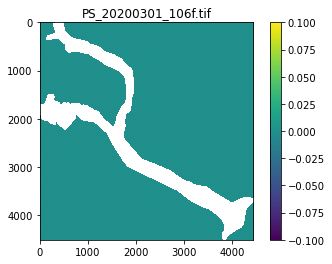

remove empty tile PS_20200301_106f.tif
Coverage is 0 % remove PS_20200301_106f.tif


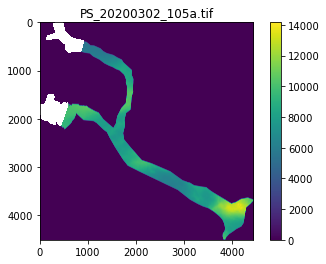

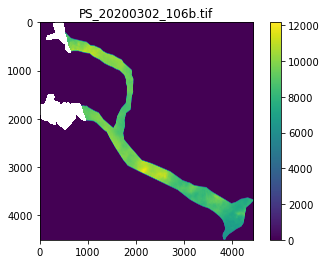

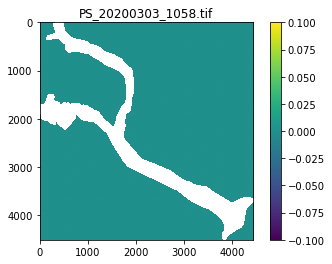

remove empty tile PS_20200303_1058.tif
Coverage is 0 % remove PS_20200303_1058.tif


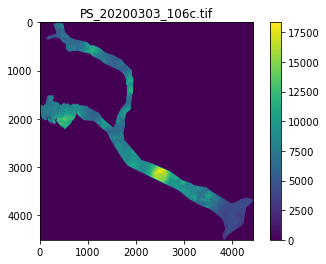

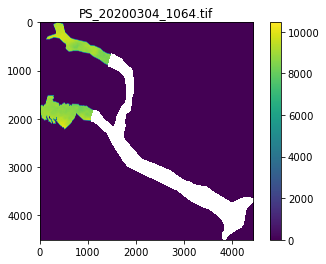

Coverage is 31 % remove PS_20200304_1064.tif


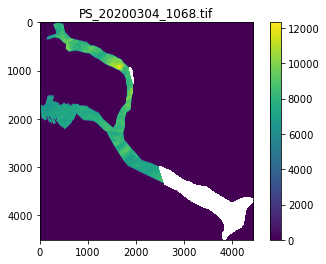

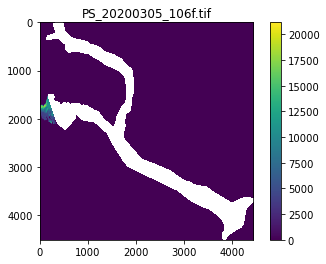

Coverage is 4 % remove PS_20200305_106f.tif


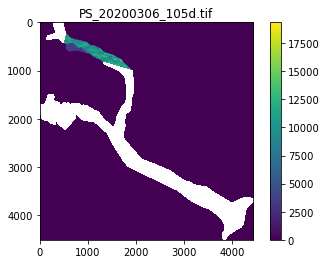

Coverage is 13 % remove PS_20200306_105d.tif


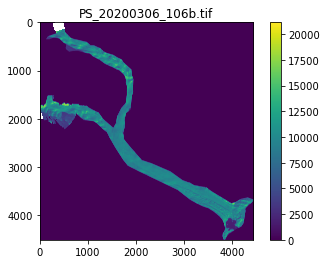

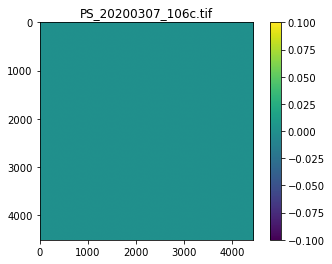

remove empty tile PS_20200307_106c.tif


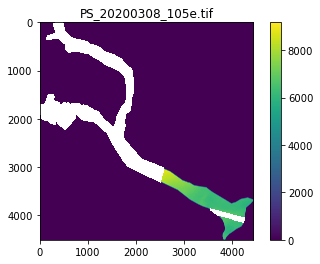

Coverage is 32 % remove PS_20200308_105e.tif


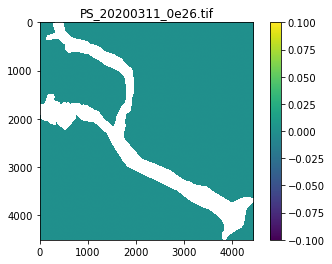

remove empty tile PS_20200311_0e26.tif
Coverage is 0 % remove PS_20200311_0e26.tif


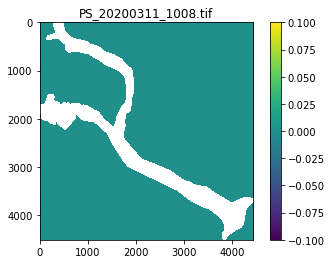

remove empty tile PS_20200311_1008.tif
Coverage is 0 % remove PS_20200311_1008.tif


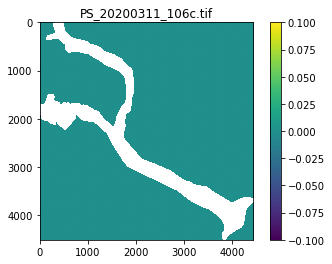

remove empty tile PS_20200311_106c.tif
Coverage is 0 % remove PS_20200311_106c.tif


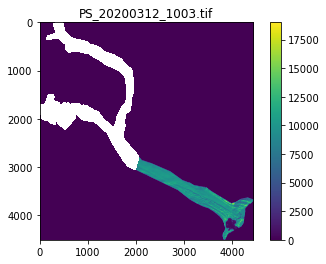

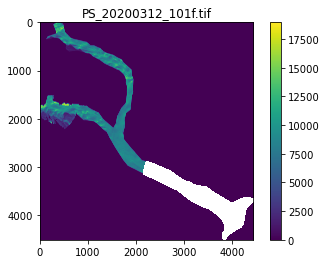

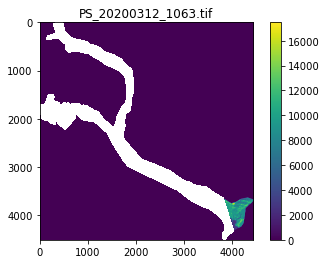

Coverage is 9 % remove PS_20200312_1063.tif


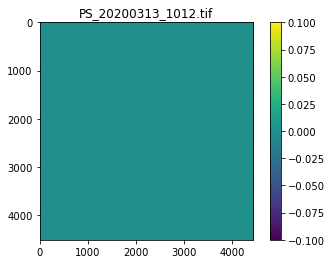

remove empty tile PS_20200313_1012.tif


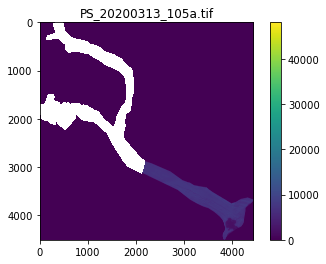

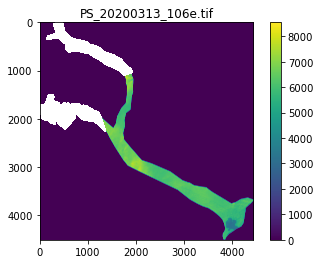

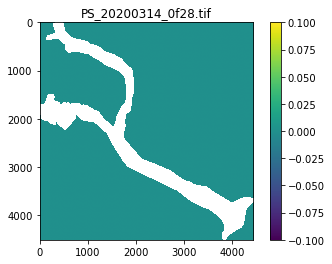

remove empty tile PS_20200314_0f28.tif
Coverage is 0 % remove PS_20200314_0f28.tif


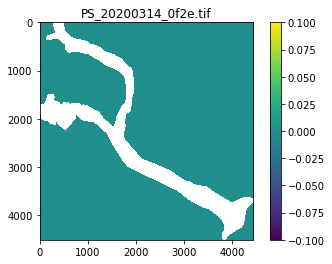

remove empty tile PS_20200314_0f2e.tif
Coverage is 0 % remove PS_20200314_0f2e.tif


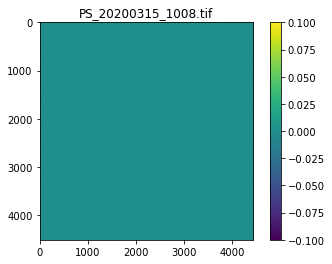

remove empty tile PS_20200315_1008.tif


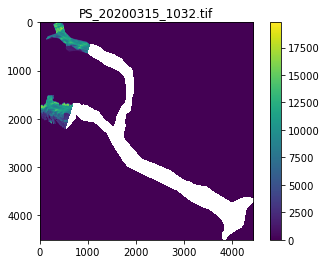

Coverage is 21 % remove PS_20200315_1032.tif


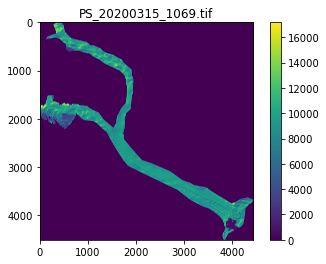

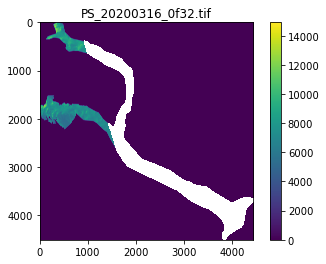

Coverage is 31 % remove PS_20200316_0f32.tif


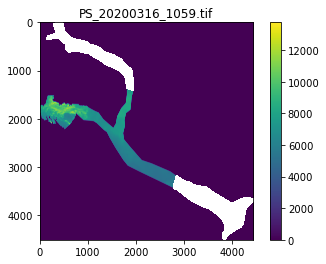

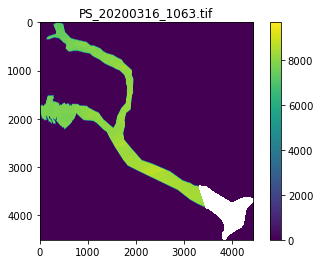

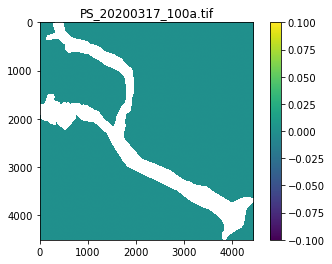

remove empty tile PS_20200317_100a.tif
Coverage is 0 % remove PS_20200317_100a.tif


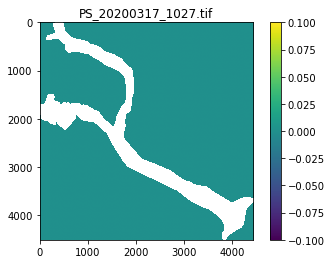

remove empty tile PS_20200317_1027.tif
Coverage is 0 % remove PS_20200317_1027.tif


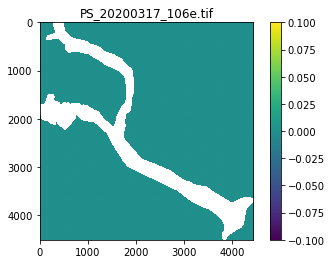

remove empty tile PS_20200317_106e.tif
Coverage is 0 % remove PS_20200317_106e.tif


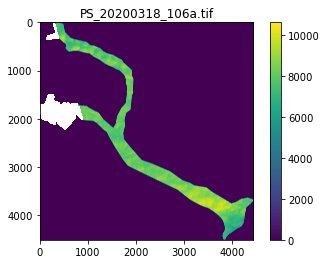

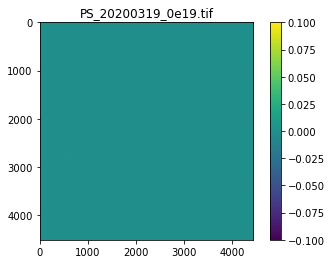

remove empty tile PS_20200319_0e19.tif


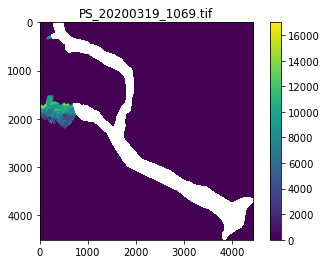

Coverage is 13 % remove PS_20200319_1069.tif


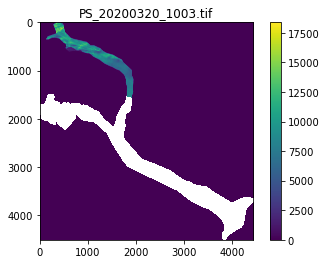

Coverage is 21 % remove PS_20200320_1003.tif


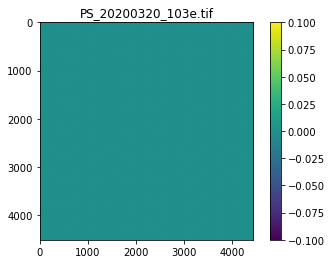

remove empty tile PS_20200320_103e.tif


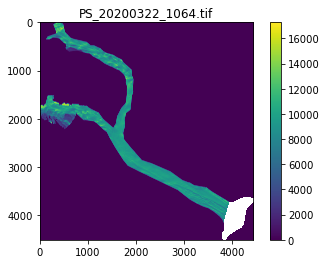

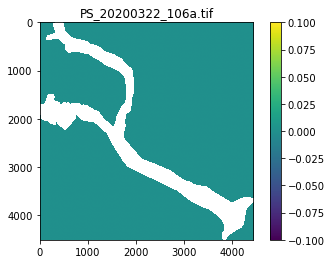

remove empty tile PS_20200322_106a.tif
Coverage is 0 % remove PS_20200322_106a.tif


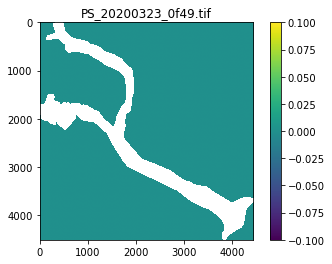

remove empty tile PS_20200323_0f49.tif
Coverage is 0 % remove PS_20200323_0f49.tif


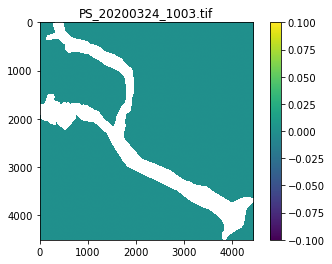

remove empty tile PS_20200324_1003.tif
Coverage is 0 % remove PS_20200324_1003.tif


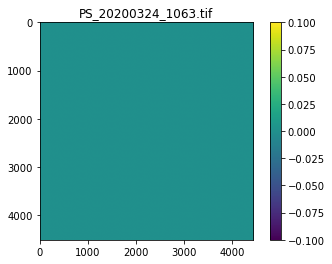

remove empty tile PS_20200324_1063.tif


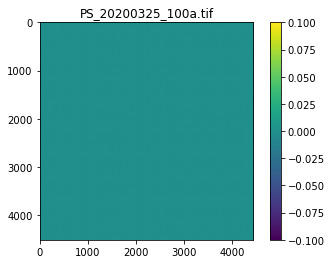

remove empty tile PS_20200325_100a.tif


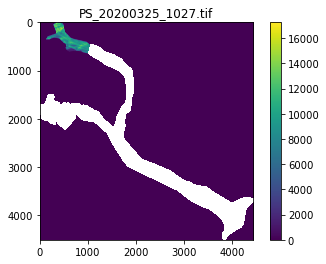

Coverage is 9 % remove PS_20200325_1027.tif


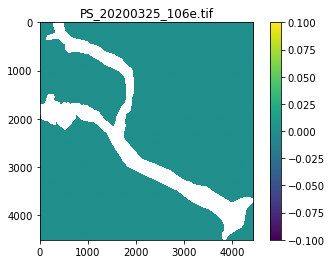

remove empty tile PS_20200325_106e.tif
Coverage is 0 % remove PS_20200325_106e.tif


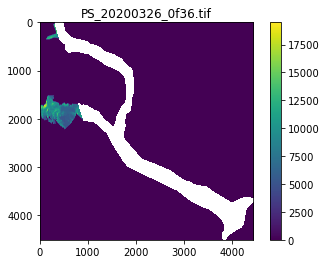

Coverage is 16 % remove PS_20200326_0f36.tif


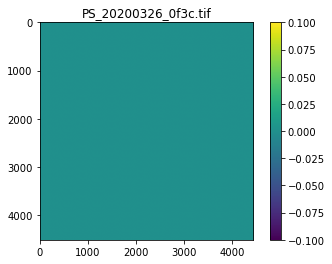

remove empty tile PS_20200326_0f3c.tif


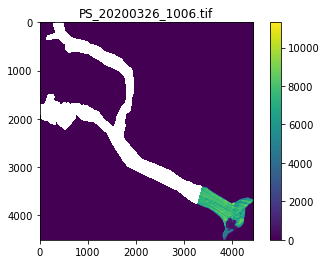

Coverage is 23 % remove PS_20200326_1006.tif


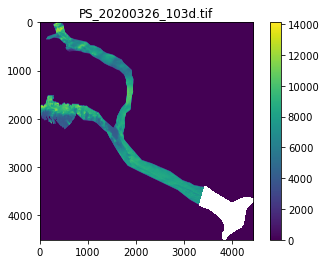

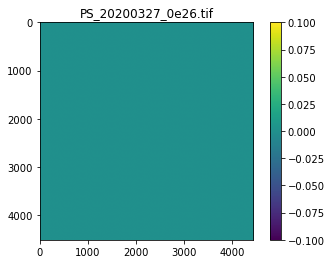

remove empty tile PS_20200327_0e26.tif


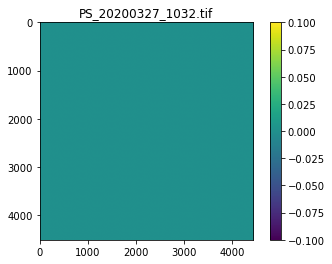

remove empty tile PS_20200327_1032.tif


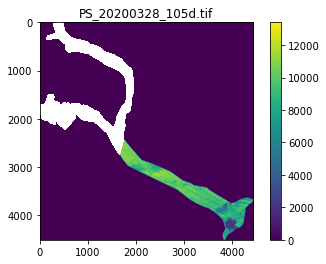

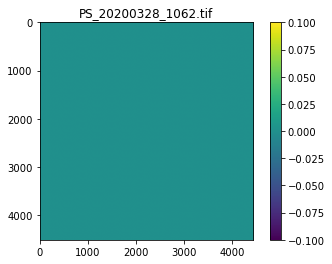

remove empty tile PS_20200328_1062.tif


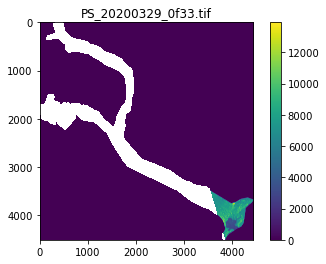

Coverage is 17 % remove PS_20200329_0f33.tif


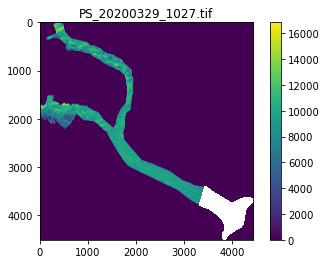

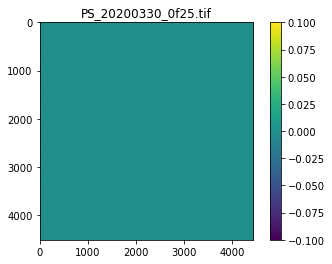

remove empty tile PS_20200330_0f25.tif


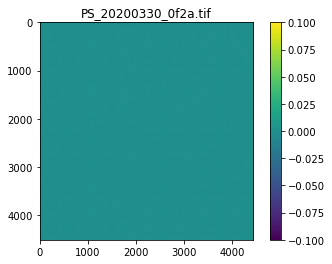

remove empty tile PS_20200330_0f2a.tif


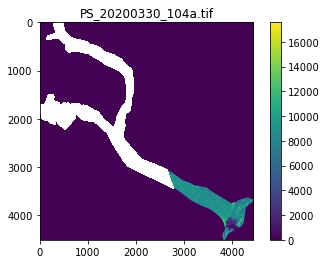

Coverage is 31 % remove PS_20200330_104a.tif


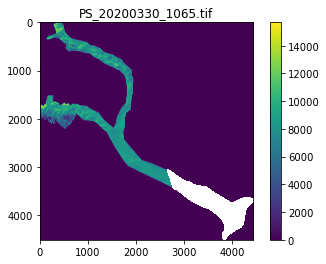

In [138]:
for newfile in os.listdir(basepath+"stitched_by_sat/"):
    if newfile.startswith('PS') and newfile.endswith('.tif'):
        reader = rio.open(basepath+"stitched_by_sat/"+newfile)
        try:
            # crop to glacier outline
            out_image, out_transform = mask(reader, [mapping(glacier[0])], crop=True)
            crop_array = out_image[0,:,:]
            
            # plot
            plt.imshow(crop_array); plt.colorbar(); plt.title(newfile)
            plt.show()
            
            # count coverage
            coverage = np.count_nonzero(crop_array[~np.isnan(crop_array)])
            
            # If image is empty, remove:
            if np.nanmax(crop_array) == 0:
                print('remove empty tile',newfile)
                os.remove(basepath+"stitched_by_sat/"+newfile)
                
            # set all nonzeros to 1 to count glacier pixels
            crop_array[crop_array != 0] = 1
            glacier_pixels = np.count_nonzero(crop_array)
            
            # if overlapping pixels is less than 25% of the total glacier pixels 
            if coverage/glacier_pixels < 0.33:
                print('Coverage is',str(int(coverage/glacier_pixels*100)),'% remove '+newfile)
                os.remove(basepath+"stitched_by_sat/"+newfile)
        except Exception:
            # if it fails to crop, then remove
#             print('remove '+tile)
            continue